In [1]:
"""
Topic:        Project 2
Subject:      Carbon Emissions
Date:         xx/xx/xxxx
Name:         Leo Knauth
Worked with:  --


""";

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

import warnings
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from pandas.tools.plotting import autocorrelation_plot

import re

import sys
import os

In [3]:
df_gdp = pd.read_pickle("gdp_per_capita.pkl")

In [4]:
df_gdp.head()

,country,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,603.0,603.0,603.0,603.0,603.0,603.0,603.0,603.0,603.0,...,1173.0,1298.0,1311.0,1548.0,1637.0,1695.0,1893.0,1884.0,1877.0,1925.0
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,667.0,667.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,...,7476.0,7977.0,8644.0,8994.0,9374.0,9640.0,9811.0,9961.0,10160.0,10620.0
4,Algeria,716.0,716.0,717.0,718.0,719.0,720.0,721.0,722.0,723.0,...,12088.0,12289.0,12314.0,12285.0,12494.0,12606.0,12779.0,12893.0,13179.0,13434.0


In [5]:
df_co2 = pd.read_pickle('co2_per_capita.pkl')

In [6]:
df_co2.head()

,country,1751,1755,1762,1763,1764,1765,1766,1767,1768,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.022704,0.027472,0.036780,0.047090,0.068312,0.131602,0.213325,0.262174,NaN,NaN
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.382066,1.332966,1.353789,1.224310,1.279420,1.297753,1.215055,1.336544,NaN,NaN
4,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.899236,2.762220,3.257010,3.113135,3.312875,3.328945,3.564361,3.480977,3.562504,3.785654


In [7]:
df_gdp.columns

Index(['country', '1800', '1801', '1802', '1803', '1804', '1805', '1806',
       '1807', '1808',
       ...
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015'],
      dtype='object', length=217)

In [8]:
select_years = list(map( lambda x : str(x), range(1962, 2013)))
select_years;

In [9]:
df_gdp_years = df_gdp[['country'] + select_years]

In [10]:
df_gdp_years.head()

,country,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1188.0,1185.0,1182.0,1182.0,1168.0,1173.0,1187.0,1178.0,1174.0,...,1097.0,1067.0,1146.0,1173.0,1298.0,1311.0,1548.0,1637.0,1695.0,1893.0
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,2832.0,2926.0,3023.0,3129.0,3242.0,3359.0,3475.0,3587.0,3712.0,...,6274.0,6672.0,7075.0,7476.0,7977.0,8644.0,8994.0,9374.0,9640.0,9811.0
4,Algeria,4481.0,5551.0,5693.0,5916.0,5478.0,5811.0,6319.0,6747.0,7227.0,...,11251.0,11575.0,12077.0,12088.0,12289.0,12314.0,12285.0,12494.0,12606.0,12779.0


In [11]:
df_gdp_clean = df_gdp_years.dropna().reset_index()

In [12]:
df_gdp_clean.drop('index', 1, inplace = True)

In [13]:
df_gdp_clean;

In [14]:
df_co2_years = df_co2[['country'] + select_years]

In [15]:
df_co2_years.head(200);

In [16]:
df_co2_clean = df_co2_years.dropna().reset_index()

In [17]:
df_co2_clean.drop('index', 1, inplace = True)

In [18]:
# df_co2_clean.loc['mean'] = df_co2_clean.mean()

In [19]:
df_co2_clean;

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


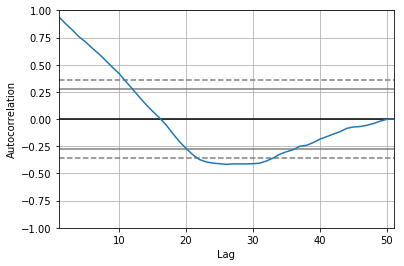

In [20]:
# autocorrelation for a sample country

autocorrelation_plot(df_co2_clean.iloc[17][1:])

In [21]:
array = np.array(df_co2_clean.iloc[17][1:])
series = df_co2_clean.iloc[17][1:]

In [22]:
model = ARIMA(array, order=(5,1,0))

In [23]:
model_fit = model.fit(disp=0)
print(model_fit.summary())

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   50
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -25.676
Method:                       css-mle   S.D. of innovations              0.404
Date:                Wed, 23 Jan 2019   AIC                             65.352
Time:                        13:41:31   BIC                             78.736
Sample:                             1   HQIC                            70.449
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0610      0.059     -1.038      0.305      -0.176       0.054
ar.L1.D.y     -0.0434      0.145     -0.299      0.766      -0.327       0.241
ar.L2.D.y     -0.0336      0.145     -0.232      0.8

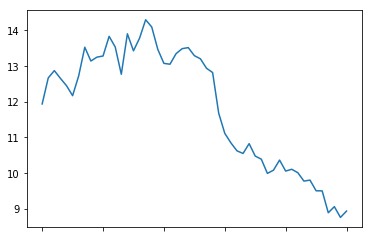

In [24]:
series.plot()

In [25]:
def fuller_test(series):
    values = series.values
    result = adfuller(values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [26]:
# difference for detrending
diff = list()
for i in range(1, len(values)):
    value = values[i] - values[i - 1]
    diff.append(value)
plt.plot(diff)

NameError: name 'values' is not defined

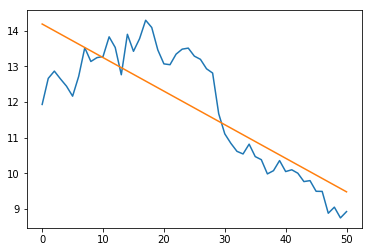

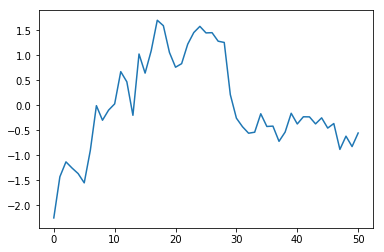

In [27]:
# detrending with linear regression

X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values

# print(y)

model = LinearRegression()
model.fit(X, y)
# calculate trend

trend = model.predict(X)
# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(series))]
# plot detrended
plt.plot(detrended)
plt.show()

In [28]:
'''
In order to use Arima I must first transpose my dataframe and set a dateIndex.

Do not know how to rename the index. 
''';

In [29]:
df_co2_transpose = df_co2_clean.transpose()
df_co2_transpose.columns = df_co2_transpose.iloc[0]
df_co2_transpose.drop('country',0, inplace = True)
# df_co2_transpose = df_co2_transpose.rename(index = str, columns={"country": "year"}) 
df_co2_transpose = df_co2_transpose.apply(pd.to_numeric)


# df_co2_transpose.index.names = ['year']
# df_co2_transpose = df_co2_transpose.reindex(df_co2_transpose.index.rename(['year']))
df_co2_transpose;
# df_co2_transpose.info()

In [30]:
def find_best_params():
    '''
    attempting to find the best
    '''
    
    
    # creating the  parameters as tuples
    p = d = q = range(0, 6)
    pdq = list(itertools.product(p, d, q))
    
    #
    for param in pdq:
        for param in pdq:
            model = sm.tsa.arima_model.ARIMA(param, )
    

In [31]:
find_best_params()

AttributeError: module 'statsmodels.tsa.api' has no attribute 'arima_model'

In [32]:
'''
filter df_gdp_clean by countries that we also have CO2 data for
'''
df_gdp_com = df_gdp_clean[df_gdp_clean['country'].isin(df_co2_clean['country'])].reset_index().drop('index', 1)

In [33]:
# df_co2_clean[df_co2_clean['country'].isin(df_gdp_clean['country'])]

In [34]:
# df_gdp_com
df_gdp_transpose = df_gdp_com.transpose()
df_gdp_transpose.columns = df_gdp_transpose.iloc[0]
df_gdp_transpose.drop('country',0, inplace = True)
# df_gdp_com = df_gdp_transpose.rename(index = str, columns={"country": "year"}) 
df_gdp_transpose = df_gdp_transpose.apply(pd.to_numeric)


# df_gdp_transpose.index.names = ['year']
# df_gdp_transpose = df_gdp_transpose.reindex(df_gdp_com.index.rename(['year']))
df_gdp_transpose.tail()
# df_gdp_com.info()

country,Algeria,Argentina,Australia,Austria,Bangladesh,Belgium,Brazil,Bulgaria,Canada,Chile,...,Switzerland,Taiwan,Thailand,Trinidad and Tobago,Turkey,United Arab Emirates,United Kingdom,United States,Venezuela,Vietnam
2008,12314.0,14646.0,41312.0,43952.0,2265.0,41641.0,13906.0,15368.0,41468.0,18698.0,...,55020.0,36526.0,12216.0,30875.0,16454.0,73029.0,37739.0,50384.0,17911.0,4085.0
2009,12285.0,14605.0,41170.0,42171.0,2355.0,40225.0,13749.0,14692.0,39884.0,18329.0,...,53179.0,36491.0,11915.0,29383.0,15467.0,60955.0,35840.0,48558.0,17056.0,4260.0
2010,12494.0,15765.0,41330.0,42861.0,2459.0,40764.0,14660.0,14886.0,40773.0,19204.0,...,54183.0,39085.0,12822.0,29321.0,16674.0,56644.0,36240.0,49373.0,16536.0,4486.0
2011,12606.0,16972.0,41706.0,44029.0,2589.0,40946.0,15101.0,15278.0,41567.0,20141.0,...,54551.0,39059.0,12798.0,28743.0,17908.0,56192.0,36549.0,49781.0,16960.0,4717.0
2012,12779.0,17101.0,42522.0,44216.0,2725.0,40687.0,15234.0,15443.0,41865.0,21050.0,...,54573.0,39482.0,13586.0,29086.0,18057.0,57028.0,36535.0,50549.0,17642.0,4912.0


In [35]:
'''
find the betas of gdp/c and co2/c per year for all countries
''';

In [36]:
# betas = {}
df_ratios = df_gdp_transpose.copy()

for year in select_years:
    
    for country in df_gdp_transpose.columns:
#         print(year)
#         print(country)
        year1 = str(year).strip()
        df_ratios.loc[year1][country] = df_co2_transpose.loc[year1][country] / df_gdp_transpose.loc[year1][country]
        
        


In [37]:
df_ratios;

In [63]:
'''
creating test data train data split
'''
df_ratios_train = df_ratios.loc['1962':'2002']
df_co2_train = df_co2_transpose.loc['1962':'2002']
df_gdp_train = df_gdp_transpose.loc['1962':'2002']

In [64]:
df_ratios_train.tail()

country,Algeria,Argentina,Australia,Austria,Bangladesh,Belgium,Brazil,Bulgaria,Canada,Chile,...,Switzerland,Taiwan,Thailand,Trinidad and Tobago,Turkey,United Arab Emirates,United Kingdom,United States,Venezuela,Vietnam
1998,0.000374,0.000311,0.000560,0.000227,0.000125,0.000336,0.000164,0.000671,0.000499,0.000266,...,0.000125,0.000285,0.000332,0.000938,0.000250,0.000284,0.000305,0.000458,0.000463,0.000253
1999,0.000312,0.000340,0.000500,0.000214,0.000126,0.000315,0.000167,0.000640,0.000474,0.000282,...,0.000120,0.000284,0.000339,0.001059,0.000253,0.000265,0.000290,0.000443,0.000508,0.000243
2000,0.000291,0.000332,0.000488,0.000206,0.000132,0.000304,0.000164,0.000599,0.000467,0.000260,...,0.000111,0.000287,0.000334,0.001071,0.000261,0.000343,0.000284,0.000440,0.000433,0.000257
2001,0.000267,0.000327,0.000473,0.000210,0.000146,0.000299,0.000167,0.000609,0.000452,0.000227,...,0.000120,0.000309,0.000350,0.001049,0.000249,0.000304,0.000280,0.000427,0.000474,0.000276
2002,0.000272,0.000342,0.000478,0.000211,0.000146,0.000276,0.000159,0.000553,0.000434,0.000233,...,0.000114,0.000309,0.000355,0.001045,0.000248,0.000247,0.000264,0.000422,0.000582,0.000301


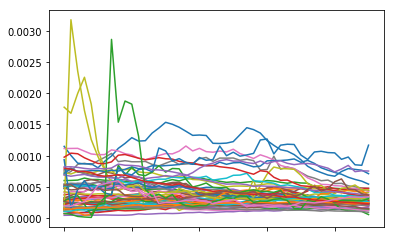

In [40]:
for country in df_ratios_train.columns:

    series = df_ratios_train[country]
    series.plot()

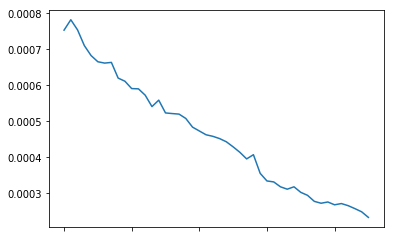

In [41]:
series = df_ratios_train['Germany']
# series = df_ratios['Germany']
series.plot()

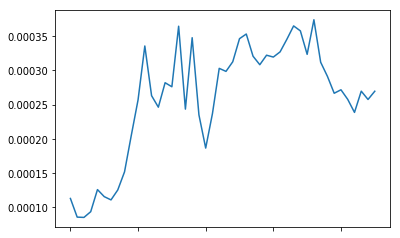

In [42]:
series = df_ratios_train['Algeria']
series.plot()

In [43]:
'''
running ARIMA on all the countries
''';

In [44]:
for country in df_ratios_train.columns:
    array = np.array(df_ratios_train[country])
    model = ARIMA(array, order=(0,1,1))
    model_fit = model.fit(disp=0)
    print('\n\n', country)
    print(model_fit.summary())

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar



 Algeria
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 389.289
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -770.577
Time:                        13:42:07   BIC                           -763.351
Sample:                             1   HQIC                          -767.883
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.591e-06   4.84e-06      0.741      0.463    -5.9e-06    1.31e-05
ar.L1.D.y     -0.3221      0.148     -2.174      0.035      -0.613      -0.032
ar.L2.D.y      0.0138      0.147      0.0

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 417.237
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -826.474
Time:                        13:42:08   BIC                           -819.247
Sample:                             1   HQIC                          -823.780
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.199e-05   2.96e-06     -4.045      0.000   -1.78e-05   -6.18e-06
ar.L1.D.y     -0.0915      0.152     -0.602      0.550      -0.389       0.206
ar.L2.D.y     -0.0578      0.160     -0.362      0.7

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)




 Canada
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 418.224
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -828.447
Time:                        13:42:08   BIC                           -821.220
Sample:                             1   HQIC                          -825.753
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.032e-06   2.98e-06     -2.362      0.023   -1.29e-05    -1.2e-06
ar.L1.D.y     -0.1315      0.148     -0.890      0.379      -0.421       0.158
ar.L2.D.y      0.0144      0.155      0.09

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)




 Egypt
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 419.854
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -831.708
Time:                        13:42:08   BIC                           -824.481
Sample:                             1   HQIC                          -829.014
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.019e-07   2.86e-06     -0.316      0.754    -6.5e-06     4.7e-06
ar.L1.D.y     -0.2210      0.151     -1.463      0.151      -0.517       0.075
ar.L2.D.y      0.1002      0.150      0.669

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)




 Hungary
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 420.299
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -832.597
Time:                        13:42:09   BIC                           -825.370
Sample:                             1   HQIC                          -829.903
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.787e-06   3.26e-06     -1.775      0.083   -1.22e-05    6.03e-07
ar.L1.D.y     -0.1579      0.150     -1.055      0.297      -0.451       0.135
ar.L2.D.y      0.1889      0.152      1.2

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)




 Iran
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 410.697
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -813.394
Time:                        13:42:09   BIC                           -806.168
Sample:                             1   HQIC                          -810.700
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.933e-06   3.14e-06      1.251      0.218   -2.23e-06    1.01e-05
ar.L1.D.y     -0.0135      0.143     -0.094      0.925      -0.295       0.268
ar.L2.D.y     -0.2439      0.142     -1.721 



 Mexico
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 440.301
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -872.601
Time:                        13:42:10   BIC                           -865.375
Sample:                             1   HQIC                          -869.907
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.188e-07   1.55e-06      0.206      0.838   -2.71e-06    3.35e-06
ar.L1.D.y     -0.3526      0.148     -2.380      0.022      -0.643      -0.062
ar.L2.D.y      0.0347      0.148      0.23

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)




 Norway
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 434.242
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -860.484
Time:                        13:42:10   BIC                           -853.257
Sample:                             1   HQIC                          -857.790
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.852e-06   2.12e-06     -0.875      0.387      -6e-06     2.3e-06
ar.L1.D.y     -0.3347      0.143     -2.339      0.024      -0.615      -0.054
ar.L2.D.y      0.2440      0.143      1.70



 Qatar
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 281.839
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -555.678
Time:                        13:42:10   BIC                           -548.451
Sample:                             1   HQIC                          -552.984
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.359e-05   3.49e-05     -0.676      0.503    -9.2e-05    4.48e-05
ar.L1.D.y     -0.5817      0.417     -1.395      0.170      -1.399       0.235
ar.L2.D.y     -0.4466      0.406     -1.099



 Spain
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 445.010
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -882.019
Time:                        13:42:11   BIC                           -874.792
Sample:                             1   HQIC                          -879.325
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.044e-07    1.7e-06     -0.474      0.638   -4.13e-06    2.52e-06
ar.L1.D.y     -0.1505      0.158     -0.951      0.347      -0.461       0.160
ar.L2.D.y      0.0653      0.158      0.413

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)




 Taiwan
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 432.645
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -857.289
Time:                        13:42:11   BIC                           -850.062
Sample:                             1   HQIC                          -854.595
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.59e-06   2.54e-06     -1.019      0.314   -7.57e-06    2.39e-06
ar.L1.D.y     -0.0111      0.150     -0.074      0.942      -0.306       0.284
ar.L2.D.y      0.0653      0.149      0.43

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 438.306
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -868.613
Time:                        13:42:12   BIC                           -861.386
Sample:                             1   HQIC                          -865.919
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.273e-05   1.97e-06     -6.460      0.000   -1.66e-05   -8.87e-06
ar.L1.D.y     -0.0106      0.148     -0.072      0.943      -0.300       0.279
ar.L2.D.y     -0.0710      0.150     -0.474      0.6

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [45]:

array = np.array(df_ratios_train['Germany'])
model = ARIMA(array, order=(0,1,1))
fit = model.fit(disp=0)

print(fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   45
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 436.728
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 23 Jan 2019   AIC                           -867.457
Time:                        13:42:12   BIC                           -862.037
Sample:                             1   HQIC                          -865.436
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.17e-05   1.66e-06     -7.041      0.000    -1.5e-05   -8.44e-06
ma.L1.D.y     -0.2506      0.163     -1.541      0.131      -0.569       0.068
                                    Roots           

In [46]:


def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

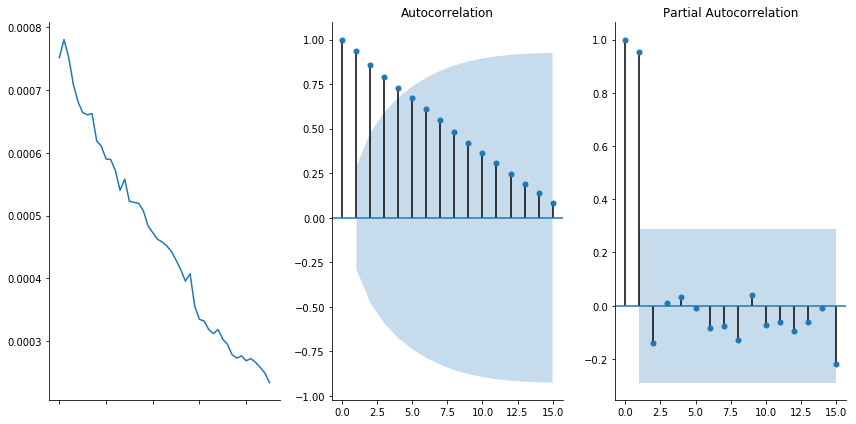

In [47]:
plots(df_ratios_train['Germany'], lags = 15)

In [48]:
df_ratios_train['Germany'].diff().std()

1.533382359127958e-05

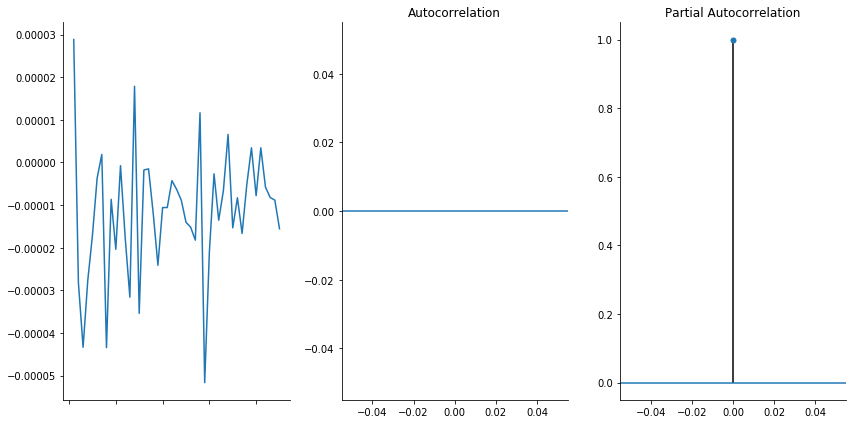

In [49]:
'''
now making it stationary with a diff function
'''

plots(df_ratios_train['Germany'].diff(), lags = 15)

In [50]:
fuller_test(df_ratios_train['Germany'])

ADF Statistic: -2.818320
p-value: 0.055704
Critical Values:
	1%: -3.589
	5%: -2.930
	10%: -2.603


In [51]:
def find_best_params(array):
    '''
    attempting to find the best
    '''
    
    
    # creating the  parameters as tuples
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    results = {}
    for param in pdq:
        
        try:
            model = ARIMA(array ,order = param )
            fit = model.fit()
            results[str(param)] = fit.aic
            
        except:
            continue

    print(min(results, key=results.get))
    return results

In [52]:
array = np.array(df_ratios_train['Germany'])
find_best_params(array)

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(0, 1, 1)


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'(0, 0, 0)': -670.719687301418,
 '(0, 0, 1)': -722.369481630081,
 '(0, 1, 0)': -866.9972634828316,
 '(0, 1, 1)': -867.4568075836017,
 '(0, 1, 2)': -865.6646615481873,
 '(0, 2, 0)': -811.660758626829,
 '(0, 2, 1)': -826.9718294927072,
 '(0, 2, 2)': -830.6655953356078,
 '(1, 0, 0)': -858.2722065963371,
 '(1, 0, 1)': -858.6188339283867,
 '(1, 0, 2)': -718.3848048085522,
 '(1, 1, 0)': -866.8717513123256,
 '(1, 1, 1)': -865.685324686348,
 '(1, 2, 0)': -823.0638335225924,
 '(1, 2, 1)': -835.6308489843043,
 '(1, 2, 2)': -834.9582799195007,
 '(2, 0, 0)': -859.7766025681836,
 '(2, 1, 0)': -865.6623938709564,
 '(2, 1, 1)': -863.5315780928387,
 '(2, 1, 2)': -860.8113546404576,
 '(2, 2, 0)': -828.2618865777338,
 '(2, 2, 1)': -832.2542957938272}

In [53]:
# array = np.array(df_ratios_train['Germany'].diff())
# find_best_params(array)

In [54]:
df_co2_train = df_co2_transpose.loc['1962':'2007']

In [55]:
array = np.array(df_co2_train['Germany'])
find_best_params(array)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


(0, 1, 0)


{'(0, 0, 0)': 169.62235308270886,
 '(0, 0, 1)': 125.48029601365137,
 '(0, 0, 2)': 105.3934569770492,
 '(0, 1, 0)': 53.36660722440348,
 '(0, 1, 1)': 55.35931680856058,
 '(0, 1, 2)': 57.128304128151115,
 '(0, 2, 0)': 82.28704571280196,
 '(0, 2, 1)': 55.79165458034538,
 '(1, 0, 0)': 58.900756817412656,
 '(1, 0, 1)': 60.870411537059695,
 '(1, 0, 2)': 62.82554798006434,
 '(1, 1, 0)': 55.36032328863274,
 '(1, 2, 0)': 73.61075774288379,
 '(1, 2, 1)': 57.699023394601156,
 '(2, 0, 0)': 60.87219794890051,
 '(2, 0, 2)': 64.29050667641644,
 '(2, 1, 0)': 57.157277752294846,
 '(2, 1, 1)': 58.55253023109542,
 '(2, 2, 0)': 68.84916761723618,
 '(2, 2, 1)': 59.168831568176756}

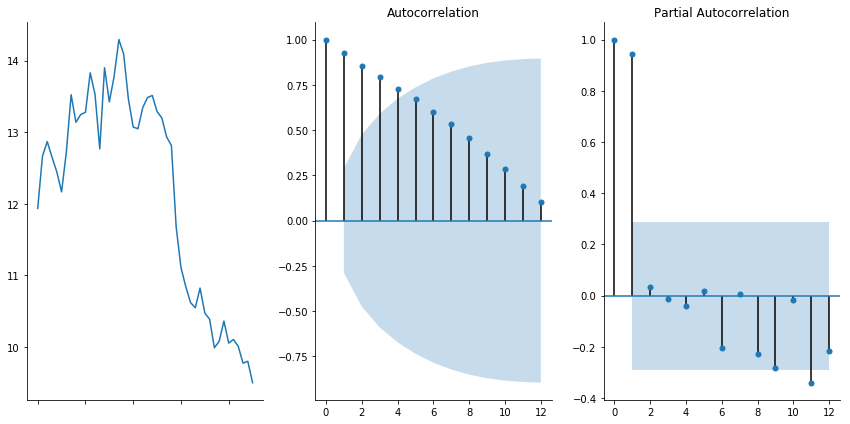

In [56]:
plots(df_co2_train['Germany'], lags = 12)

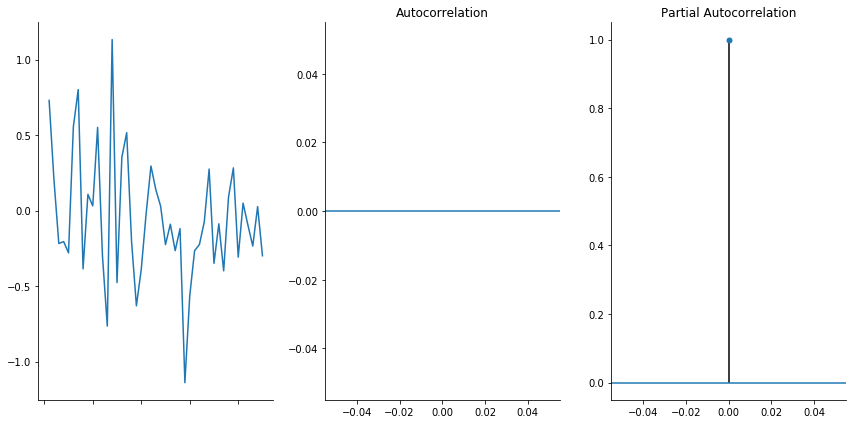

In [57]:
plots(df_co2_train['Germany'].diff(), lags = 12)

In [59]:
fuller_test(df_co2_train['Germany'])

ADF Statistic: -0.098328
p-value: 0.949605
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


In [122]:
'''
creating train beta df
'''



reg_years = list(map( lambda x : str(x), range(1962, 2003)))
reg_years;
df_betas = df_co2_train.copy()
df_betas['beta'] = np.nan
df_betas.head()
for year in reg_years:
    lr1 = LinearRegression()
    x = np.array(df_gdp_train.loc[year])
    y = np.array(df_co2_train.loc[year])
    lr1.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    df_betas.loc[year]['beta'] = (lr1.coef_[0][0])
df_betas = df_betas[['beta']]

In [139]:
''' 
creating validation beta df

'''




reg_years = list(map( lambda x : str(x), range(2003, 2008)))
reg_years;
df_betas_val = df_co2_transpose.copy()
df_betas_val['beta'] = np.nan
df_betas_val.head()
for year in reg_years:
    lr1 = LinearRegression()
    x = np.array(df_gdp_transpose.loc[year])
    y = np.array(df_co2_transpose.loc[year])
    lr1.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    df_betas_val.loc[year]['beta'] = (lr1.coef_[0][0])
df_betas_val = df_betas_val[['beta']]
df_betas_val = df_betas_val.loc['2003':'2007']

In [144]:
''' 
creating test beta df

'''




reg_years = list(map( lambda x : str(x), range(2007, 2013)))
reg_years;
df_betas_test = df_co2_transpose.copy()
df_betas_test['beta'] = np.nan
df_betas_test.head()
for year in reg_years:
    lr1 = LinearRegression()
    x = np.array(df_gdp_transpose.loc[year])
    y = np.array(df_co2_transpose.loc[year])
    lr1.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    df_betas_test.loc[year]['beta'] = (lr1.coef_[0][0])
df_betas_test = df_betas_test[['beta']]
df_betas_test = df_betas_test.loc['2008':'2012']

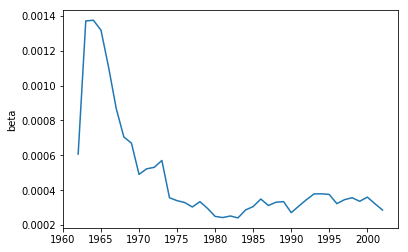

In [129]:
sns.lineplot(y = df_betas['beta'], x = df_betas.index.values.astype(int))

In [163]:
# fuller_test(df_betas_test['beta'])

In [131]:
'''
finding the best params for training data betas
'''

array = np.array(df_betas['beta'])
find_best_params(array)

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

(1, 0, 2)


{'(0, 0, 0)': -544.21546586958,
 '(0, 0, 1)': -579.0946028722481,
 '(0, 1, 0)': -590.6447546738391,
 '(0, 1, 1)': -589.4930999016954,
 '(0, 1, 2)': -594.7357085177512,
 '(0, 2, 0)': -574.0680821097778,
 '(0, 2, 1)': -572.477001624781,
 '(0, 2, 2)': -574.1109155764569,
 '(1, 0, 0)': -604.9097084029092,
 '(1, 0, 1)': -605.8411593958157,
 '(1, 0, 2)': -612.5535312614661,
 '(1, 1, 0)': -590.6353010724688,
 '(1, 1, 1)': -588.2884626903368,
 '(1, 2, 0)': -572.9213633300709,
 '(2, 0, 0)': -610.5934472574938,
 '(2, 0, 1)': -609.608232976526,
 '(2, 0, 2)': -612.3338779886321,
 '(2, 1, 0)': -588.5751654383904,
 '(2, 1, 1)': -586.4743089091373,
 '(2, 2, 0)': -573.1978670272607,
 '(2, 2, 1)': -569.1395567899391,
 '(2, 2, 2)': -569.4448644288187}

In [140]:
df_betas_val

country,beta
2003,0.000325
2004,0.000330
2005,0.000335
2006,0.000313
2007,0.000305


In [145]:
df_betas_test

country,beta
2008,0.000290
2009,0.000275
2010,0.000262
2011,0.000252
2012,0.000270


In [157]:
predictions = []
df_beta_hist = df_betas.copy()

val_years = list(map( lambda x : (x), range(2003, 2008)))
for year in val_years:
    model = ARIMA(df_betas, order = (1, 0, 2))
    fit = model.fit()
    pred = fit.predict(start = 2002, end= year)[0][0]
    predictions.append(pred)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 2263-01-01 00:00:00